Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
          Date       Open       High  ...     EMA 12     EMA 26      MACD
0   2015-01-02  94.910004  95.279999  ...  93.750000  93.750000  0.000000
1   2015-01-05  93.279999  93.349998  ...  93.007915  93.038652 -0.030737
2   2015-01-06  92.570000  93.190002  ...  92.571592  92.625952 -0.054360
3   2015-01-07  92.720001  93.150002  ...  92.653162  92.682996 -0.029834
4   2015-01-08  93.870003  94.300003  ...  92.962037  92.939715  0.022322
5   2015-01-09  94.0

Text(0, 0.5, 'USD')

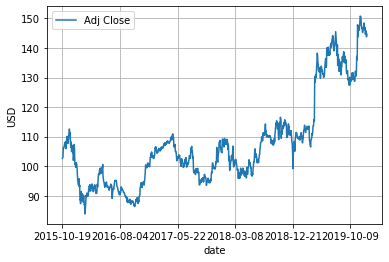

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from google.colab import drive
# Mounting Google Drive for using files. Remove if not needed.
drive.mount('/content/drive')
# The current URL is for a file on my Google Drive.
# Change it accordingly to the location of your test file.
url = '/content/drive/My Drive/COMP3900 Data/DIS.csv'
dataset = pd.read_csv(url)

# Creating additional techincal analysis features to help predictions
# MA is moving average over x number of previous days
# EMA is exponential moving average over x number of previous days
# MACD is moving average convergence divergence
def get_technical_analysis(dataset):
  dataset['MA 7'] = dataset['Close'].rolling(window=7).mean()
  dataset['MA 20'] = dataset['Close'].rolling(window=20).mean()
  dataset['MA 50'] = dataset['Close'].rolling(window=50).mean()
  dataset['MA 200'] = dataset['Close'].rolling(window=200).mean()
  dataset['EMA 20'] = dataset['Close'].ewm(span=20).mean()
  dataset['EMA 50'] = dataset['Close'].ewm(span=50).mean()
  dataset['EMA 200'] = dataset['Close'].ewm(span=200).mean()
  dataset['EMA 12'] = dataset['Close'].ewm(span=12).mean()
  dataset['EMA 26'] = dataset['Close'].ewm(span=26).mean()
  dataset['MACD'] = dataset['EMA 12'] - dataset['EMA 26']

get_technical_analysis(dataset)
print(dataset.head(20))
include = ['Date', 'Adj Close', 'Volume', 
           'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
features = ['Adj Close', 'Volume', 'MA 7', 'MA 20', 'MA 50', 'MA 200', 
           'EMA 12', 'EMA 20', 'EMA 26', 'EMA 50', 'EMA 200', 'MACD']
print(dataset.shape)
dataset = dataset[200:]
print(dataset.shape)
ax = dataset.plot(x='Date', y='Adj Close', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [0]:
# This function is to split data into 
# x values (input values to make predictions),and y values (correct output)
def get_xy(data, lags, num_predictions):
  x = []
  y = []
  for i in range(lags, len(data) - num_predictions):
    x.append(np.array(data[i-lags:i]))
    y.append(np.array(data[i:i+num_predictions]))
  x = np.array(x)
  y = np.array(y)[:,:,0]
  y = y.reshape(y.shape + (1,))
  return x, y

# Function for testing accuracy. MAPE (Mean absolute percentage error) is 
# a really common way to measure accuracy, where the lower the MAPE value, the better
def get_mape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
import random
def predict(dataset, forecasts, lags, dates):
  x, y = get_xy(np.array(dataset), lags, forecasts)
  x = x.reshape(x.shape[0], x.shape[1], feature_sets)
  print(x.shape)
  print(np.array(dataset).shape)
  all_preds = []
  # Making predictions every FORECAST number of days
  for a in range(0, len(x), forecasts):
    scalers = [MinMaxScaler() for a in range(feature_sets)]
    xa = x[a]
    # Feature scaling
    for feature_num in range(feature_sets):
      xa[:,feature_num] = scalers[feature_num].fit_transform(np.array(xa[:, feature_num]).reshape(-1,1)).reshape(-1)
    preds = model.predict(xa.reshape(1, -1, feature_sets))
    preds = scalers[0].inverse_transform(preds)
    all_preds.extend(preds.flatten())
  all_preds = np.array(all_preds)
  y = y.reshape(y.shape[0], -1)
  # Scoring the model
  actual_adj = np.array(dataset['Adj Close']).reshape(-1)[lags:len(all_preds)+lags]
  dates = dates[lags:len(all_preds) + lags]
  mape = get_mape(actual_adj, all_preds)
  print('MAPE: {}'.format(mape))
  # Going through the whole graph to see how we performed in a general sense
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1), 'Date': dates[0:len(all_preds)]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj, 'Date': dates[:len(all_preds)]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')
  # Gets a random date then gets the predictions from there
  index = random.randint(0,len(x)-forecasts)
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds[index:index+forecasts], 'Date': dates[index:index+forecasts]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj[index:index+forecasts], 'Date': dates[index:index+forecasts]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')
  # Gets a random date then gets the 3 * FORECAST number of predictions from there
  # so that we can get a better look at the predictions
  multi_day = 3*forecasts
  index = random.randint(0,len(x)-multi_day)
  preds_graph = pd.DataFrame({'Predicted Adj Close': all_preds.reshape(-1)[index:index+multi_day], 'Date': dates[index:index+multi_day]})
  test_y = pd.DataFrame({'Actual Adj Close': actual_adj[index:index+multi_day], 'Date': dates[index:index+multi_day]})
  graph = test_y.plot(x='Date', y='Actual Adj Close', grid=True)
  graph = preds_graph.plot(x='Date', y="Predicted Adj Close", ax=graph, grid=True)
  graph.set_xlabel('date')
  graph.set_ylabel('AUD')


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 250)           263000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 250)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 100)           140400    
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 64)               

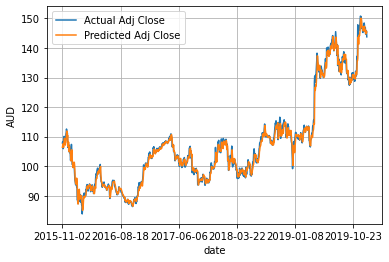

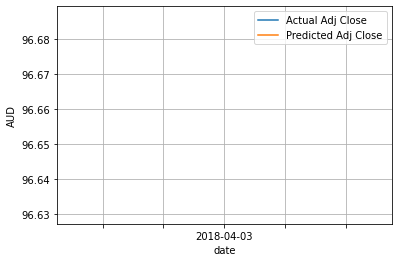

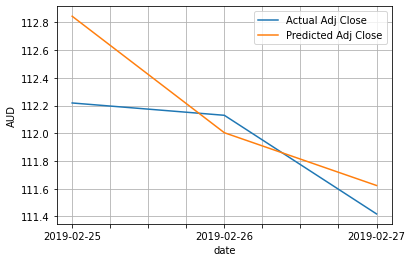

In [0]:
forecasts = 1
lags = forecasts * 10 if forecasts < 10 else 100
feature_sets = len(features)
test = dataset
# location will depend on where you have placed the model,
# but if you are running it locally, use the location there.
# The current location is a location on Google Drive.
model = tf.keras.models.load_model('/content/drive/My Drive/COMP3900 Data/model_{}.h5'.format(forecasts))
model.summary()
test_adj = test[features]
predict(test_adj, forecasts, lags, test['Date'])